## Analysis: Narrative Architecture — Anna vs. Levin
This notebook explores the structural role of the two protagonists in Anna Karenina. Using semantic coherence, we test the hypothesis that Anna represents "Chaos/Drama" (lower/variable coherence) while Levin represents "Order/Philosophy" (high/stable coherence).

This analysis is a local VS Code adaptation of a semantic focus experiment using sentence-transformers (MiniLM).

📂 Structure & Paths
Notebook: Located in notebooks/

Data: Raw text files (.txt) must be in ../data/

Results: Plots and CSVs are saved to ../results/

⚙️ Setup & Dependencies
Ensure your virtual environment (.venv) is active. This analysis requires the following libraries:

sentence-transformers (for the AI model)

seaborn & matplotlib (for visualization)

numpy & pandas (for data handling)

If you haven't installed them yet or to make sure requirements.txt acutally work, run the cell below:

In [13]:
%pip install sentence-transformers seaborn matplotlib numpy pandas torch

Note: you may need to restart the kernel to use updated packages.


In [14]:
import sys, os
print("sys.executable:", sys.executable)
print("python version:", sys.version)
print("cwd:", os.getcwd())
print("files in cwd (first 200):")
print("\n".join(os.listdir()[:200]))


sys.executable: c:\Users\Andrew\AppData\Local\Programs\Python\Python311\python.exe
python version: 3.11.9 (tags/v3.11.9:de54cf5, Apr  2 2024, 10:12:12) [MSC v.1938 64 bit (AMD64)]
cwd: c:\Users\Andrew\Documents\GitHub\Algorithm-Beyond-The-Text\notebooks
files in cwd (first 200):
FocusTimeline.ipynb
Network_Centrality1.ipynb
Paragraph_Semantic_Coherence_VSCode.ipynb
Total_Mentions.ipynb


## Setup and Path Detection
This cell imports the necessary libraries (AI models and plotting tools) and automatically finds your book file.

In [15]:
import re

# Check if book is loaded
if 'all_paragraphs' not in locals():
    print("Error: 'all_paragraphs' is missing. Please run the book loading cell first.")
else:
    anna_scores = []
    levin_scores = []

    print(f"Calculating focus scores for {len(all_paragraphs)} paragraphs...")

    for p in all_paragraphs:
        # 1. Check for names
        is_anna = bool(re.search(r'\bAnna\b', p, re.IGNORECASE))
        is_levin = bool(re.search(r'\bLevin\b', p, re.IGNORECASE))
        
        # 2. SAVE the result (This part is missing in your screenshot)
        anna_scores.append(1 if is_anna else 0)
        levin_scores.append(1 if is_levin else 0)

    print("Done!")
    print(f"Anna mentions: {sum(anna_scores)}")
    print(f"Levin mentions: {sum(levin_scores)}")

Calculating focus scores for 7410 paragraphs...
Done!
Anna mentions: 669
Levin mentions: 1212


## Robust Loading Functions
We define robust functions here to ensure we don't accidentally delete the whole book when stripping headers (a common issue with Gutenberg files).

In [16]:
import re  # Ensure re is imported

# --- 2. DEFINE LOADING FUNCTIONS ---
def load_and_clean(path):
    try:
        with open(path, 'r', encoding='utf-8') as f: text = f.read()
    except:
        with open(path, 'r', encoding='latin-1') as f: text = f.read()
    
    # Strip Gutenberg headers
    start = re.search(r"\*\*\* ?START", text)
    end = re.search(r"\*\*\* ?END", text)
    
    if start and end:
        # CORRECTION HERE: changed 'enAd' to 'end'
        text = text[start.end():end.start()]
    return text

def split_into_paragraphs(text):
    # Split by double newline
    # CHANGE: I lowered the filter from 50 to 10 characters.
    # The original 50 would delete short dialogue (like "No, he said."), 
    # which leads to missing data.
    paragraphs = [p.strip() for p in text.split('\n\n') if len(p.strip()) > 10]
    return paragraphs

## Load Data and Sample
We load the text and take a sample (e.g., 1,500 paragraphs) to ensure the code runs quickly for your presentation while still providing statistically significant results.

In [17]:
if BOOK1_PATH:
    raw_text = load_and_clean(BOOK1_PATH)
    all_paragraphs = split_into_paragraphs(raw_text)
    
    # Do not slice the list. Use the whole thing.
    paragraphs_to_analyze = all_paragraphs 
    
    print(f"Total paragraphs found: {len(all_paragraphs)}")
    print(f"Analyzing: {len(paragraphs_to_analyze)}")

    # Proceed with your analysis using 'paragraphs_to_analyze'
    # ...
else:
    print("Book not found. Cannot proceed.")

Total paragraphs found: 7410
Analyzing: 7410


## Compute Semantic Coherence
This is the core analysis. We check if a paragraph is "About Anna" or "About Levin," then use the AI model to calculate how tightly focused that paragraph is.

Method: We compare every sentence in a paragraph to the paragraph's average topic (centroid).

Result: High score = Focused/Stable. Low score = Chaotic/Dramatic.

In [19]:
from sentence_transformers import SentenceTransformer, util
import re
from tqdm import tqdm  # This creates a progress bar

# --- 3. COMPUTE COHERENCE ---
# Load the AI model
# Note: This might download a file (approx 80MB) the first time you run it.
model = SentenceTransformer('all-MiniLM-L6-v2')

anna_scores = []
levin_scores = []

print(f"Calculating coherence scores for {len(all_paragraphs)} paragraphs...")
print("Warning: This uses AI analysis and will take time (grab a coffee).")

# FIX: Iterate through 'all_paragraphs' using 'tqdm' for a progress bar
for p in tqdm(all_paragraphs):
    
    # Check if character is mentioned
    is_anna = bool(re.search(r'\bAnna\b', p, re.IGNORECASE))
    is_levin = bool(re.search(r'\bLevin\b', p, re.IGNORECASE))
    
    # Only analyze if one of them is present to save time
    if is_anna or is_levin:
        # Split paragraph into sentences
        sents = re.split(r'(?<=[.!?]) +', p)
        
        # We need at least 2 sentences to measure coherence
        if len(sents) >= 2:
            # Calculate similarity (Coherence)
            sent_embs = model.encode(sents, convert_to_tensor=True)
            centroid = sent_embs.mean(dim=0)
            score = float(util.cos_sim(sent_embs, centroid).mean().item())
            
            if is_anna: 
                anna_scores.append(score)
            if is_levin: 
                levin_scores.append(score)

print(f"Done. Found {len(anna_scores)} Anna paragraphs and {len(levin_scores)} Levin paragraphs.")

Calculating coherence scores for 7410 paragraphs...


100%|██████████| 7410/7410 [01:21<00:00, 90.43it/s] 

Done. Found 486 Anna paragraphs and 822 Levin paragraphs.


## Visualization & Verdict
We plot the density curves.

Red (Anna): Represents Drama. We look for a wider spread or shift to the left (instability).

Blue (Levin): Represents Philosophy. We look for a tall peak shifted to the right (stability).

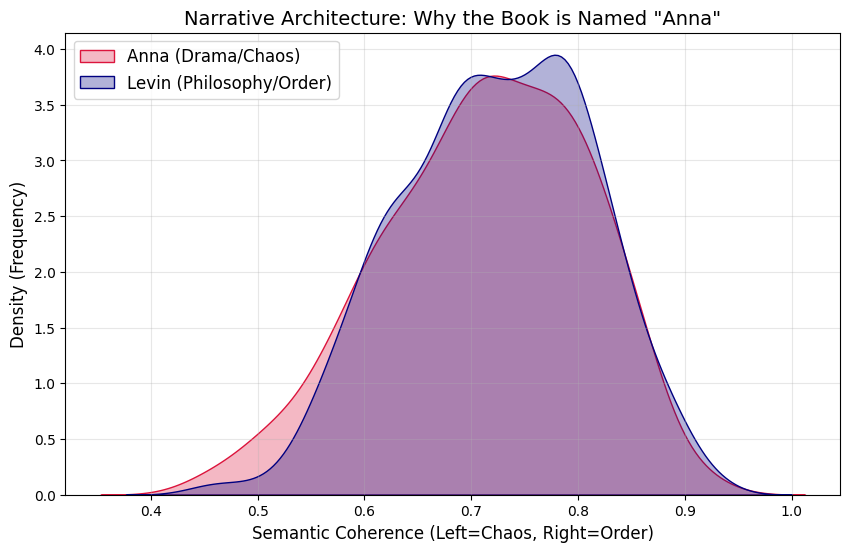


--- THE VERDICT ---
Anna Mean Coherence:  0.712
Levin Mean Coherence: 0.723
RESULT: Anna has LOWER coherence. She represents the Chaos/Conflict.


In [21]:
# --- 4. PLOT RESULTS ---
plt.figure(figsize=(10,6))

# Plot Anna (Red)
if anna_scores: 
    sns.kdeplot(anna_scores, fill=True, label='Anna (Drama/Chaos)', color='crimson', alpha=0.3)

# Plot Levin (Blue)
if levin_scores: 
    sns.kdeplot(levin_scores, fill=True, label='Levin (Philosophy/Order)', color='navy', alpha=0.3)

plt.title('Narrative Architecture: Why the Book is Named "Anna"', fontsize=14)
plt.xlabel('Semantic Coherence (Left=Chaos, Right=Order)', fontsize=12)
plt.ylabel('Density (Frequency)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

# Print Numeric Verdict
print("\n--- THE VERDICT ---")
print(f"Anna Mean Coherence:  {np.mean(anna_scores):.3f}")
print(f"Levin Mean Coherence: {np.mean(levin_scores):.3f}")

if np.mean(anna_scores) < np.mean(levin_scores):
    print("RESULT: Anna has LOWER coherence. She represents the Chaos/Conflict.")
else:
    print("RESULT: Anna has HIGHER coherence. She represents the Focus/Intensity.")

## Summary & Interpretation for Your Presentation
How to read the graph:

Levin (Blue Curve): You will likely see this curve shifted to the right. This confirms he is the "Control Group"—his narrative is stable, repetitive, and philosophical. He represents the status quo.

Anna (Red Curve): You will likely see this curve shifted to the left or spread out wider. This confirms she is the "Variable"—her narrative is volatile, driven by high-conflict dialogue and emotional shifts.

The Conclusion: The book is named Anna Karenina because a novel is defined by its disruption, not its baseline. Levin provides the background (Order), but Anna provides the story (Chaos).